# Phase III: First ML Model Proof of Concept
## Project Goal:
Our project aims to explore the factors contributing to high unemployment rates in the United States, with a specific focus on how economic indicators such as inflation, trade balances, and education levels impact unemployment. By leveraging data from reliable sources like the FRED API, this project aims to provide insights that will assist policymakers, businesses, and job seekers in making informed decisions related to labor market dynamics.

Specifically, we ask: What role do economic indicators, such as inflation and trade balances, play in driving unemployment rates in the U.S.? How does the level of education impact an individual's chances of being unemployed in the U.S.?

Implementation of our initial ML model using only math and NumPy

## How does the relationship between CPI (Consumer Price Index) and GDP (Gross Domestic Product) compare when using nominal GDP versus real GDP (adjusted for inflation)?

In [8]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Difference in Dataframe Cleaning

Note that I had to change the dataframe to impute based on the last value. Because economic data is released at different times, I normalized the date as the first of every month and imputed based on the most recent previous economic data. I had to do this because regressions require complete datasets. Especially if we look into multi-linear regressions complete datasets are necessary. While this technique sacrifices some accuracy, the regression will still provide an accurate sense of direction. 

In [11]:
def fetch_fred_data(series_id, api_key):
    '''
    Fetch data from FRED API for a given series ID.
    
    Args:
        series_id (str): The series ID to fetch.
        api_key (str): The FRED API key.
        
    Returns:
        pd.DataFrame: DataFrame containing the series data with date and values.
    '''
    base_url = 'https://api.stlouisfed.org/fred/series/observations'
    url = f"{base_url}?series_id={series_id}&api_key={api_key}&file_type=json"

    response = requests.get(url)
    json_data = response.json()

    series_data = []

    # Get the observations and filter out invalid values
    for item in json_data['observations']:
        value = item['value']
        if value != ".":
            series_data.append({
                'Date': item['date'],
                series_id: float(value)
            })

    # Convert the series data to a DataFrame
    return pd.DataFrame(series_data)

In [13]:
def fetch_and_combine_data(series_ids, api_key):
    '''
    Fetch data for multiple FRED series IDs and merge them into a single DataFrame.
    Resamples data to monthly frequency using backward fill.
    '''
    data_dict = {}

    # Fetch data for each series and store it in the dictionary
    for series_id in series_ids:
        df = fetch_fred_data(series_id, api_key)
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df.set_index('Date', inplace=True)

        # Resample data to monthly frequency
        if series_id == 'GDP':
            # Use backward fill for quarterly data
            df = df.resample('MS').bfill()
        else:
            # For monthly data, ensure it is at the start of the month
            df = df.resample('MS').mean()
            # Apply backward fill to fill any remaining NaN values
            df = df.bfill()

        data_dict[series_id] = df

    # Merge all DataFrames on the index (Date) using outer join
    df_merged = pd.concat(data_dict.values(), axis=1, join='outer')

    # Reset the index to get 'Date' back as a column
    df_merged = df_merged.reset_index()

    # Sort by Date to ensure the DataFrame is properly ordered
    df_merged = df_merged.sort_values('Date').reset_index(drop=True)

    # Apply backward fill to the merged DataFrame
    df_merged = df_merged.bfill()

    df_merged['Year'] = df_merged['Date'].dt.year.astype('category')

    return df_merged

In [15]:
series_ids = {
    'UNRATE': 'Unemployment Rate',
    'UNEMPLOY': 'Unemployment Level',
    'GDP': 'Gross Domestic Product',          # Nominal GDP
    'GDPC1': 'Real Gross Domestic Product',   # Real GDP
    'CPIAUCSL': 'Consumer Price Index',
    'LNS12027660': 'Employment Level - High School Graduates, No College',
    'LNS12027662': 'Employment Level - Bachelor Degree and Higher'
}

api_key = 'cfd78155258b4613d94a4eba555758f9'
df_merged = fetch_and_combine_data(series_ids, api_key)
df_merged = df_merged.dropna()
df_merged.tail()

,Date,UNRATE,UNEMPLOY,GDP,GDPC1,CPIAUCSL,LNS12027660,LNS12027662,Year
926,2024-03-01,3.8,6429.0,29016.714,23223.906,312.230,34866.0,63095.0,2024
927,2024-04-01,3.9,6492.0,29016.714,23223.906,313.207,34757.0,63047.0,2024
928,2024-05-01,4.0,6649.0,29349.924,23386.248,313.225,34785.0,63622.0,2024
929,2024-06-01,4.1,6811.0,29349.924,23386.248,313.049,34709.0,63800.0,2024
930,2024-07-01,4.3,7163.0,29349.924,23386.248,313.534,35015.0,63724.0,2024


In [16]:
def m_vals(x_col, y_col, ):
    # Extract the columns from the DataFrame
    X = df_merged[x_col].to_numpy()  # X values (GDP, for example)
    y = df_merged[y_col].to_numpy()  # y values (CPIAUCSL, for example)
    
    # Create the matrix X with a column of ones for the intercept
    X_matrix = np.vstack([X, np.ones(len(X))]).T  # Shape: (n_samples, 2)
    
    # Calculate m using normal equation: m = (X.T * X)^-1 * X.T * y
    XtX = np.matmul(X_matrix.T, X_matrix)
    XtXinv = np.linalg.inv(XtX)
    
    Xty = np.matmul(X_matrix.T, y)
    
    m = np.matmul(XtXinv, Xty)  # m contains [slope, intercept]
    
    return m

In [19]:
def pearson_corr(x, y):
    '''
    Returns the calculated pearon coefficient
    '''
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sqrt(np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2))
    
    return numerator / denominator

Pearson correlation coefficient between GDP and CPIAUCSL: 0.9757671034019724


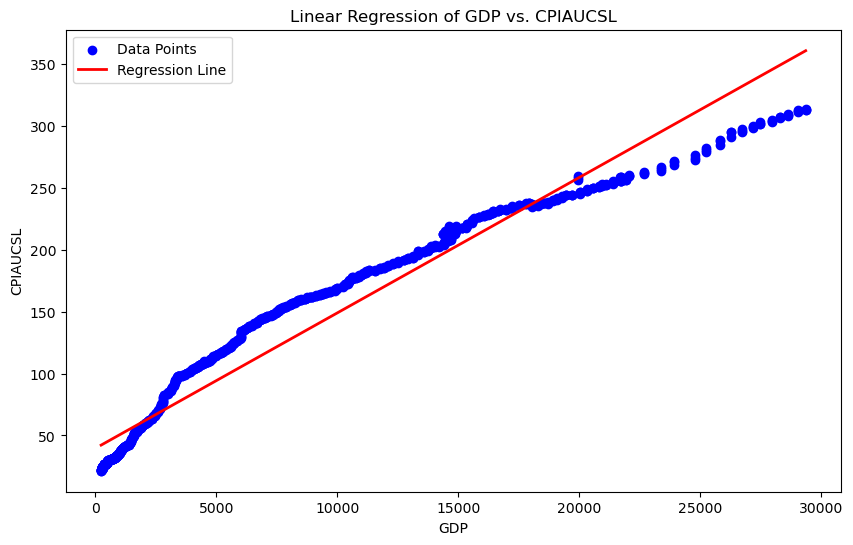

Pearson correlation coefficient between GDPC1 and CPIAUCSL: 0.9932797199093623


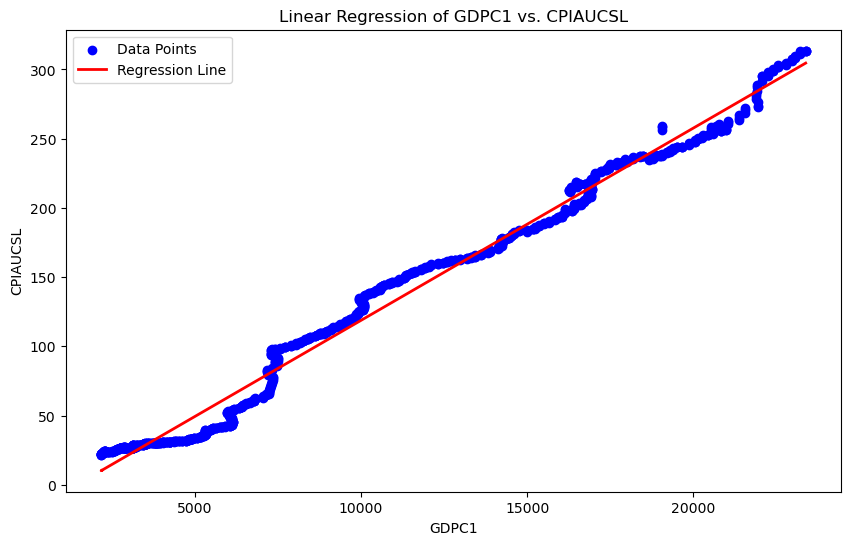

In [21]:
def ml_plots(df, x_col, y_col):
    # Get m values 
    m = m_vals(x_col, y_col)
    
    X_var = df[x_col].to_numpy()
    y_var = df[y_col].to_numpy()
    
    # Calculate Pearson correlation coefficient manually
    corr_coef = pearson_corr(X_var, y_var)
    print(f"Pearson correlation coefficient between {x_col} and {y_col}: {corr_coef}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X_var, y_var, color='blue', label='Data Points')
    
    # Calculate the y-values for the regression line based on X_var and m
    y_line = m[0] * X_var + m[1]
    
    plt.plot(X_var, y_line, color='red', linewidth=2, label='Regression Line')
    plt.xlabel(f'{x_col}')
    plt.ylabel(f'{y_col}')
    plt.title(f'Linear Regression of {x_col} vs. {y_col}')
    plt.legend()
    plt.show()

ml_plots(df_merged, 'GDP', 'CPIAUCSL')  # CPI vs nominal GDP
ml_plots(df_merged, 'GDPC1', 'CPIAUCSL')  # CPI vs real GDP

# Checking Assumptions

## Independence

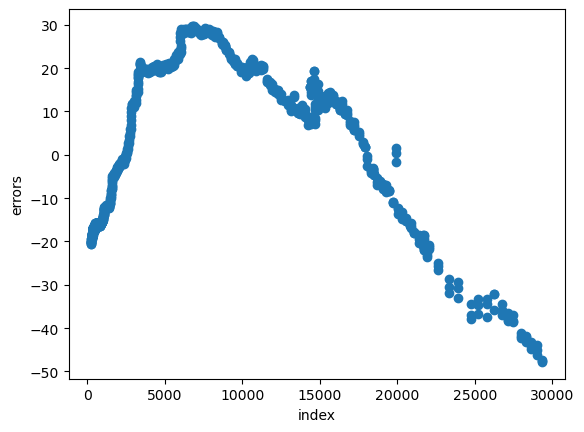

In [40]:
#Independence for GDP
m = m_vals('GDP', 'CPIAUCSL')
y_pred = m[1] + m[0]*df_merged['GDP']
errors = df_merged['CPIAUCSL'] - y_pred
plt.scatter(x = df_merged['GDP'], y = errors)
plt.xlabel('index')
plt.ylabel('errors');

-20.01367451980164


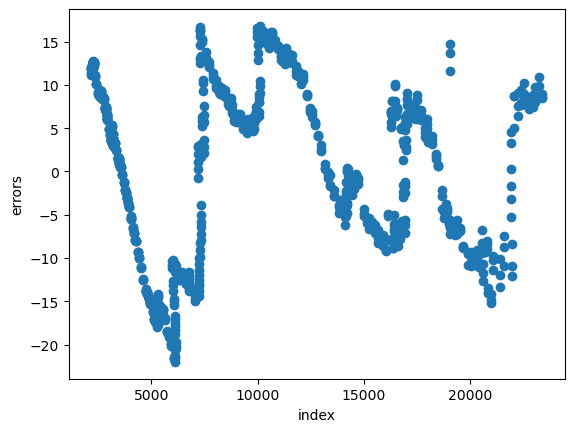

In [27]:
#Independence for GDPCP1
m2 = m_vals('GDPC1', 'CPIAUCSL')
y_pred2 = m2[1] + m2[0]*df_merged['GDPC1']
errors2 = df_merged['CPIAUCSL'] - y_pred2
plt.scatter(x = df_merged['GDPC1'], y = errors2)
plt.xlabel('index')
plt.ylabel('errors');
print(m2[1])

## Interpretation (Add more info for Phase 3)

1. The relationship between CPI and nominal GDP shows a somewhat linear trend, though there is a slight divergence where the CPI increases at a slower rate as nominal GDP rises. This suggests that inflation may have a non-linear effect on nominal GDP, where nominal GDP grows faster than the CPI in some parts of the data range.

2. The relationship between CPI and real GDP appears more linear compared to the nominal GDP graph. The CPI follows a more consistent trend with real GDP, reflecting a stronger correlation between these two variables. This indicates that, when adjusted for inflation, GDP and CPI have a more direct linear relationship, suggesting that CPI grows more in line with real economic output than it does with nominal figures that are affected by inflation.

## Normality

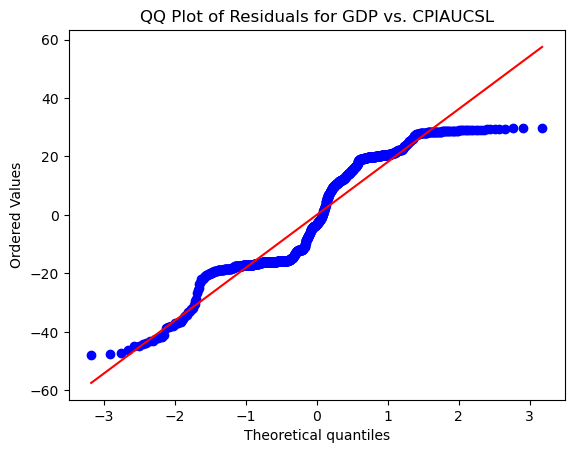

In [31]:
import scipy.stats as stats
# Checking Normality for GDP
# Generate QQ plot for GDP residuals
stats.probplot(errors, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals for GDP vs. CPIAUCSL')
plt.show()

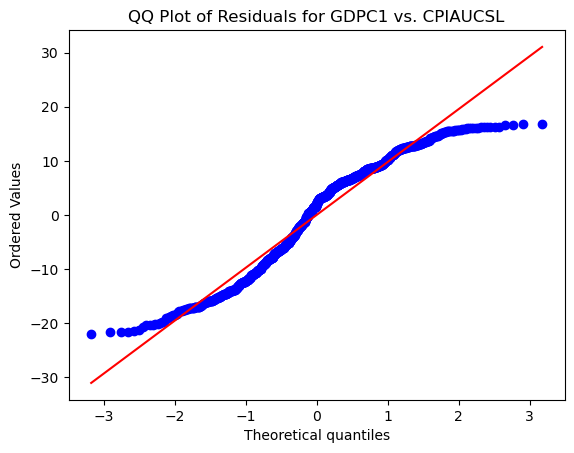

In [33]:
# Checking Normality for GDPCP1
# Generate QQ plot for GDPC1 residuals
stats.probplot(errors2, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals for GDPC1 vs. CPIAUCSL')
plt.show()

## Interpretation (Add more info for Phase 3)
3. The QQ plot for residuals of CPI against nominal GDP suggests a partial adherence to normality. While the middle quantiles align reasonably well with the reference line, the deviations at both the lower and upper tails indicate potential issues with extreme values. These deviations suggest the presence of outliers or non-linearity in the residuals, which may affect the overall reliability of the regression model. The divergence at the tails implies that the residuals are not perfectly normal, and the model's assumptions might be partially violated. In other words, this suggests that nominal GDP is influenced by factors that create variations not fully captured by the linear relationship with CPI.
4. The QQ plot for residuals of CPI against real GDP (GDPC1) shows a much stronger adherence to normality compared to nominal GDP. Most points lie along the reference line, with minimal deviations at the tails. This indicates that the residuals are approximately normally distributed, which supports the validity of the regression model for GDPC1 and CPI. The strong linear trend in the QQ plot emphasizes that real GDP provides a more stable and predictable relationship with CPI, aligning well with the assumptions of the linear regression model. The deviations suggest that the model captures the relationship effectively without significant bias from non-normal residuals.

## Constant Variance and Linearity

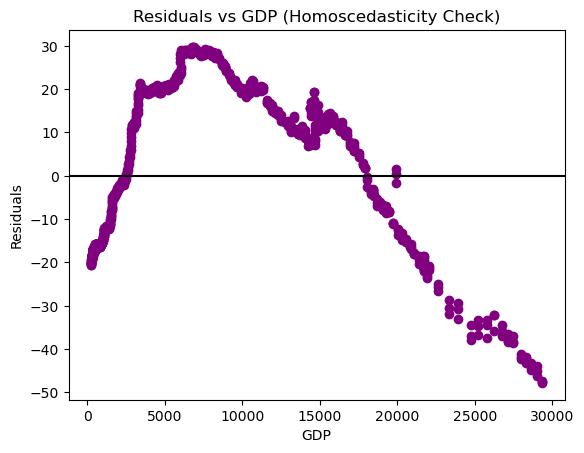

In [93]:
# Homoscedasticity check for GDP vs CPIAUCSL
plt.scatter(df_merged['GDP'], errors, color='purple', label='Residuals vs GDP')
plt.xlabel('GDP')
plt.ylabel('Residuals')
plt.title('Residuals vs GDP (Homoscedasticity Check)')
plt.axhline(y=0, color='black', linestyle='-')
plt.show()

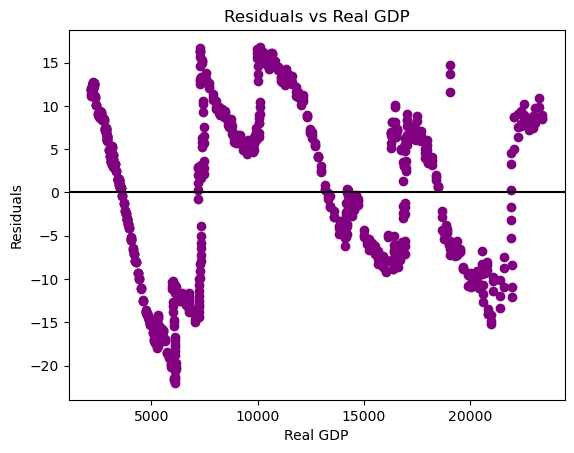

In [98]:
# Homoscedasticity check for Real GDP vs CPIAUCSL
plt.scatter(df_merged['GDPC1'], errors2, color='purple', label='Residuals vs GDPC1')
plt.xlabel('Real GDP')
plt.ylabel('Residuals')
plt.title('Residuals vs Real GDP')
plt.axhline(y=0, color='black', linestyle='-')
plt.show()

## Interpretation 

1. These are the same graphs that are used to determine independence, however, in the context of independence, we are checking that there is no correlation between the variables (a data point does not depend on the value of another data point). When checking for constant variance and linearity, we want to look at the spread of the residuals. The curved shape in the Residuals vs. GDP implies that there may be non-linearity in the data and that the variance is not constant (meaning heteroscedasticity as opposed to homoscedasticity). 

2. When checking Residuals vs Real GDP, the spread of the residuals is more scattered and does not follow any sort of pattern (neither line or curve). In this case, constant variance (homoscedasticity) is met. This implies that the assumptions for this model are more closely met and validated. We can infer that because Real GDP adjusts for inflation, GDP and CPI have a more direct relationship that are not as influenced by other factors. 